In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import pickle
import helper_functions_06b as hf

In [2]:
DATE = ['20230302']#, '20230305']
SESSION = ['SM_Lek1']#, 'SE_Lek1']
DRONE = ['P1D1', 'P1D2', 'P2D3', 'P2D4', 'P3D5', 'P3D6']

tracking_directory = '/Volumes/EAS_shared/blackbuck/working/processed/Field_Recording_2023/TestRegistration'

In [3]:
# Thresholds for translation, rotation, and scale
thresholds = {
    'T_translation': 30,  # e.g., 30 pixels
    'T_rotation': 20,     # e.g., 20 degrees
    'T_scale': 0.1         # e.g., 10% change
}

In [4]:
for date in DATE:
    for session in SESSION:
        for drone in DRONE:
            print(date, session, drone)
            
            internal_path = tracking_directory + '/' + date + '/' + session + '/' + drone
            files = glob.glob(internal_path + '/' + date + '_' + session + '_' + drone + '*_tracked.csv')
            
            for file in sorted(files):
                df = pd.read_csv(file)
                
                df['x'] = df['bb_left'] + df['bb_width']/2
                df['y'] = df['bb_top'] + df['bb_height']/2
                df['idx'] = df['track_id']

                df = df.loc[:,['frame', 'x', 'y', 'idx']]
                
                # Step 1: Identify anchor frames
                anchor_frames = hf.identify_anchor_frames(df, thresholds)

                # Step 2: Find the best anchor for each frame
                df = hf.find_best_anchor_for_each_frame_parallel(df, anchor_frames)

                # Step 3: Apply homography using the best anchor for each frame
                df, homography_matrices, rms_errors = hf.apply_homography_to_best_anchor(df)
                
                anchor_filename = os.path.basename(file).replace('_YOLO_tracked.csv', '_Anchored.csv')
                pickle_filename = os.path.basename(file).replace('_YOLO_tracked.csv', '_homographies.pkl')
                df.to_csv(os.path.join(os.path.dirname(file), anchor_filename), index=False, mode='w')
                with open(os.path.join(os.path.dirname(file), pickle_filename), 'wb') as f:
                    pickle.dump(homography_matrices, f)

20230302 SM_Lek1 P1D1
Initial identification of anchors takes  14.123930215835571
Finding the best anchors took 242.12751507759094
Applying homography to the best anchors takes  143.6713309288025
Initial identification of anchors takes  13.761142015457153
Finding the best anchors took 137.6449737548828
Applying homography to the best anchors takes  143.55983996391296
20230302 SM_Lek1 P1D2
Initial identification of anchors takes  17.434157848358154
Finding the best anchors took 594.662143945694
Applying homography to the best anchors takes  152.02444100379944
Initial identification of anchors takes  19.08825707435608
Finding the best anchors took 551.5418291091919
Applying homography to the best anchors takes  144.14456605911255
20230302 SM_Lek1 P2D3
Initial identification of anchors takes  14.080145835876465
Finding the best anchors took 106.66331505775452
Applying homography to the best anchors takes  179.16531205177307
Initial identification of anchors takes  16.579704761505127
Findi

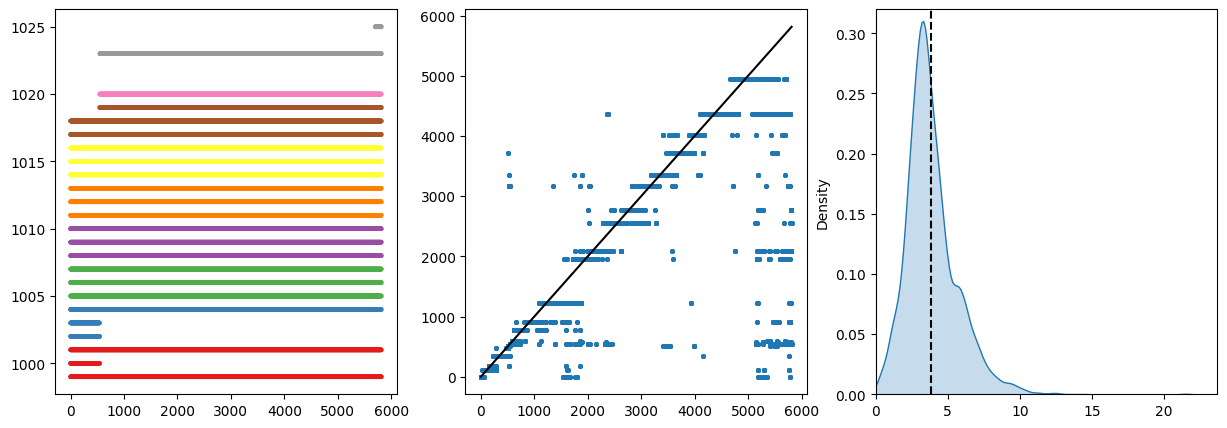

In [5]:
mean_rms_error = sum(rms_errors.values()) / len(rms_errors)


fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.scatter(df['frame'], df['idx'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)

ax2.scatter(df['frame'], df['best_anchor_frame'], s=5)
ax2.plot(np.linspace(0,df['frame'].max()), np.linspace(0,df['frame'].max()), c='black')

sns.kdeplot(rms_errors, fill=True, ax=ax3)
ax3.vlines(mean_rms_error,0,0.32,color='black',linestyles='dashed')
ax3.set_xlim(0,)
ax3.set_ylim(0,0.32)

plt.show()